In [1]:
from mne_bids import (BIDSPath,read_raw_bids)
import mne_bids
import mne
import importlib
import ccs_eeg_utils
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt

/home/yannick/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def plot_data(data, sampling_rate=500, start=0, end=7):
    # Calculate start and end indices
    start_idx = int(start * sampling_rate)
    end_idx = int(end * sampling_rate) + 1

    # Generate time axis
    time_axis = np.arange(start_idx, end_idx) / sampling_rate

    # Plot the data
    plt.plot(time_axis, data[0][0].T[start_idx:end_idx])
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"EEG Signal from {start} to {end} seconds")
    plt.show()

In [3]:
bids_root = "./data/"
subject_id = '001'


bids_path = BIDSPath(subject=subject_id, run="02", task="ContinuousVideoGamePlay",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
clear_output()

In [4]:
raw.load_data()
raw_unmodified = raw.copy()

Reading 0 ... 1398674  =      0.000 ...  2797.348 secs...


In [18]:
raw = raw_unmodified.copy()

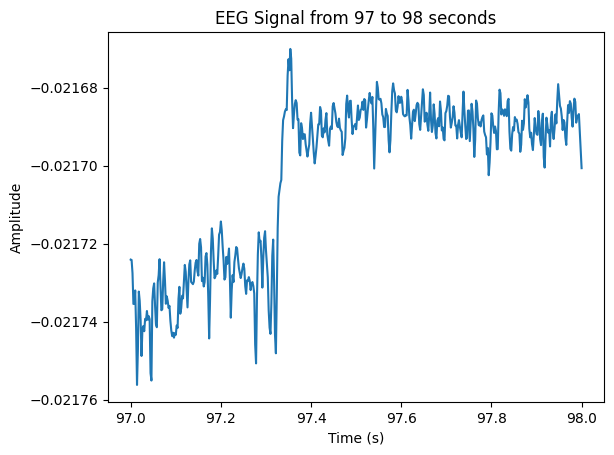

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


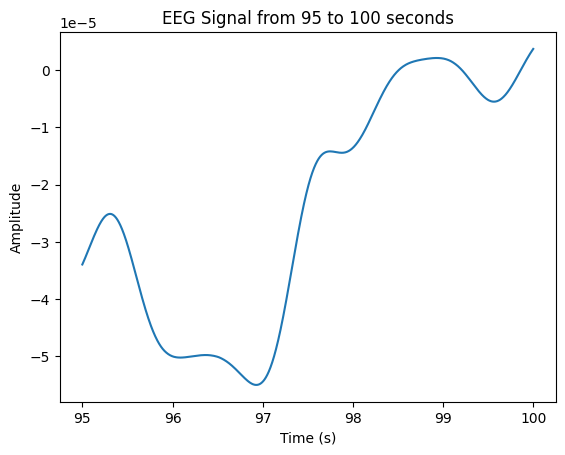

/home/yannick/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/yannick/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


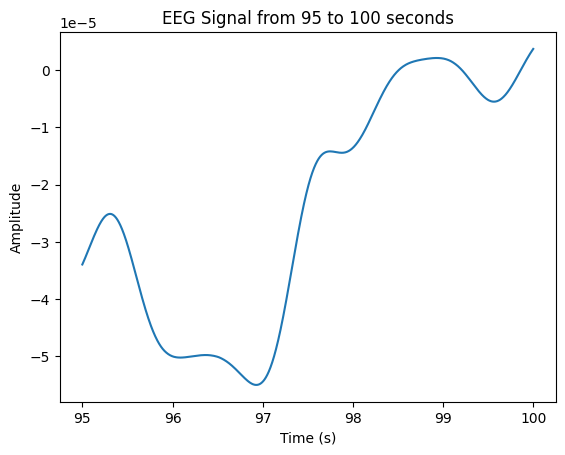

In [23]:
#Pipeline as suggested by paper
raw = raw_unmodified.copy()
plot_data(raw, start=97, end=98)
raw.filter(0.01, 0.1, picks="all")
plot_data(raw, start=95, end=100)
raw.apply_hilbert(picks="all")
plot_data(raw, start=95, end=100)
# raw.resample(100)
# plot_data(raw, 100)

In [7]:
raw = raw_unmodified.copy()
raw.filter(0.01, 0.1, picks="all")
raw.apply_hilbert(picks="all")
test = np.angle(raw.get_data(picks="all"))


No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.10 Hz)
- Filter length: 165001 samples (330.002 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


In [8]:
test[12].shape

(1398675,)

In [9]:
def create_bins(data, num_bins=8):
    bin_size = 2 * np.pi / num_bins
    bins = []
    for i in range(num_bins):
        bins.append([])
    for element in data:
        bin_index = int((element + np.pi) // bin_size)
        bins[bin_index].append(element)
    return bins

In [10]:
bins = create_bins(test[12])

<BarContainer object of 8 artists>

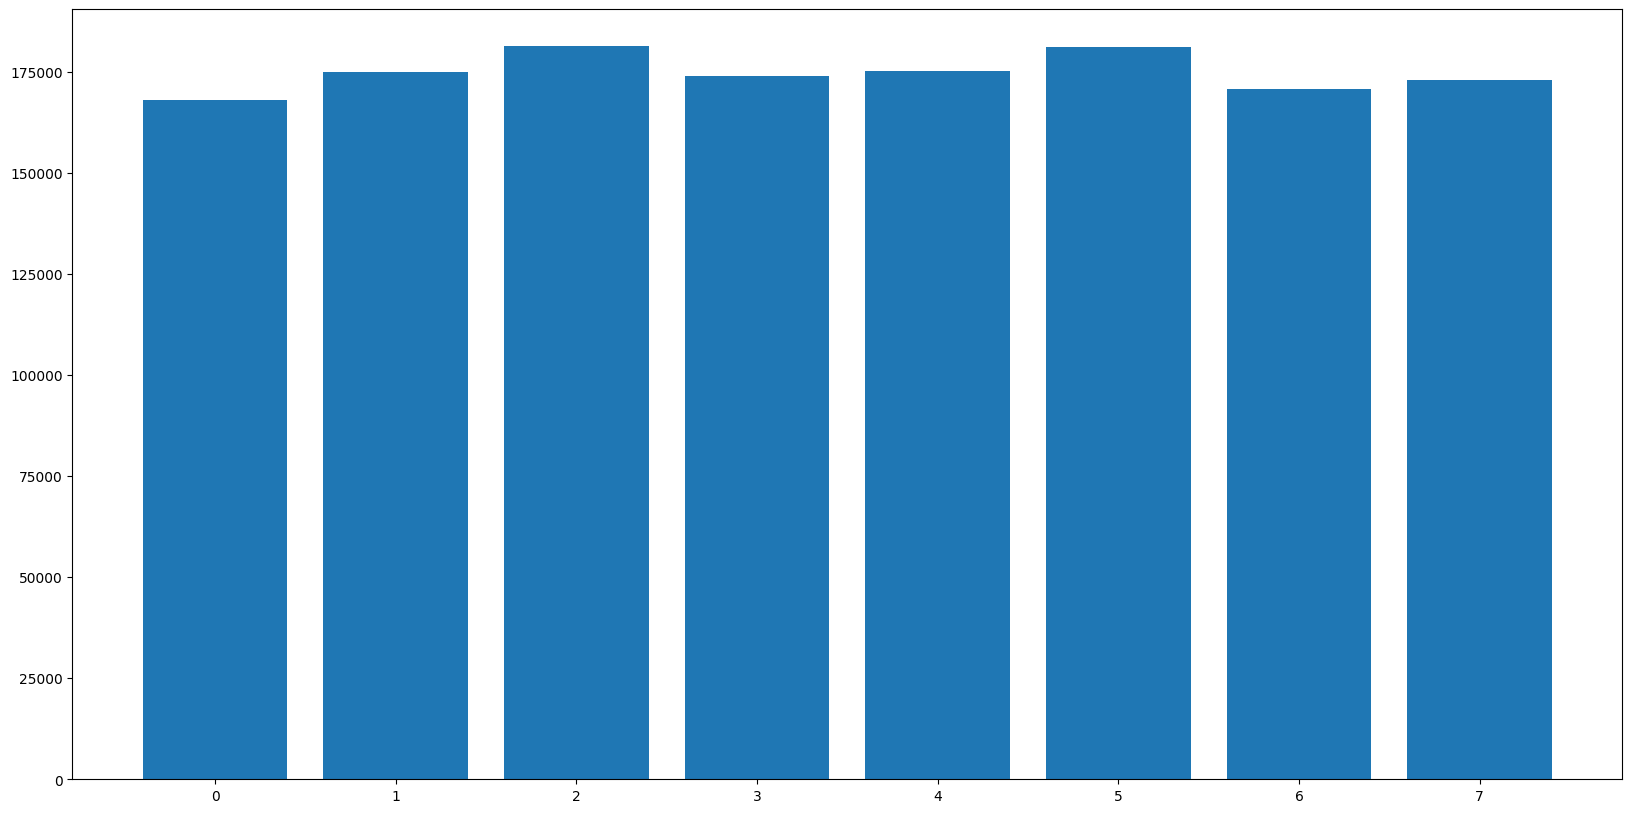

In [11]:
#plot angles
plt.figure(figsize=(20,10))
plt.bar([i for i in range(8)], [len(bins[i]) for i in range(8)])

## Compute bin standard deviation
- For each event calculate difference to standard deviation

In [24]:
def get_bin_probabilities(bins):
    sum = 0
    for bin in bins:
        sum += len(bin)
    return [len(bin)/sum for bin in bins]

def get_bin_deviation(data, timestamp, timespan = 0.1*500):
    bins = create_bins(data)
    default = get_bin_probabilities(bins)
    
    event_bins = create_bins(data[int((timestamp-timespan/2)):int((timestamp+timespan/2))])
    event_probability = get_bin_probabilities(event_bins)

    deviation = []
    for i  in range(len(default)):
        deviation.append(abs(default[i]-event_probability[i]))

    return deviation

def get_total_deviation(data, timestamp, timespan = 0.1, sampling_rate = 500):
    total_deviation = [0 for i in range(8)]
    for i in range(len(data)):
        deviation = get_bin_deviation(data[i], timestamp*sampling_rate, timespan*sampling_rate)
        for i in range(len(deviation)):
            total_deviation[i] += deviation[i]
        
    for i in range(len(total_deviation)):
        total_deviation[i] /= len(data)
    return total_deviation


In [29]:
data = test[10:11]

<BarContainer object of 8 artists>

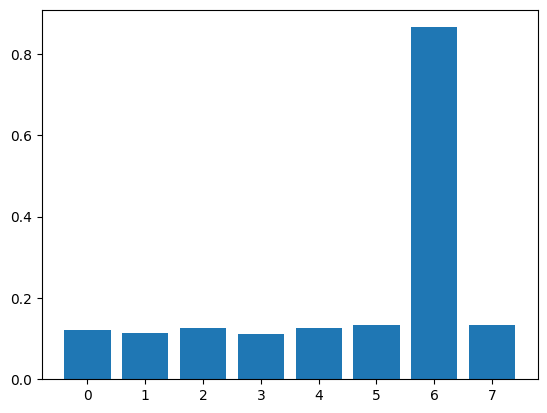

In [30]:
total_deviation = get_total_deviation(data, 115.014)
plt.bar([i for i in range(8)], total_deviation)

<BarContainer object of 8 artists>

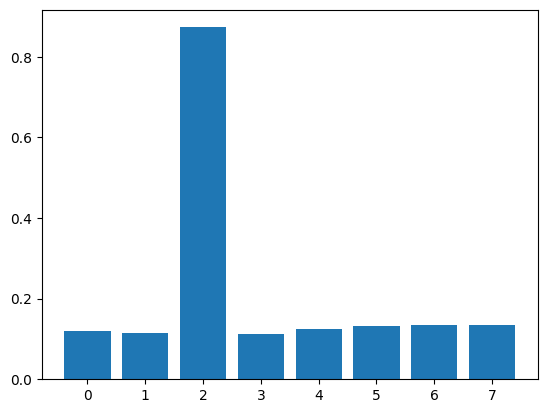

In [31]:
total_deviation = get_total_deviation(data, 147.868)
plt.bar([i for i in range(8)], total_deviation)

<BarContainer object of 8 artists>

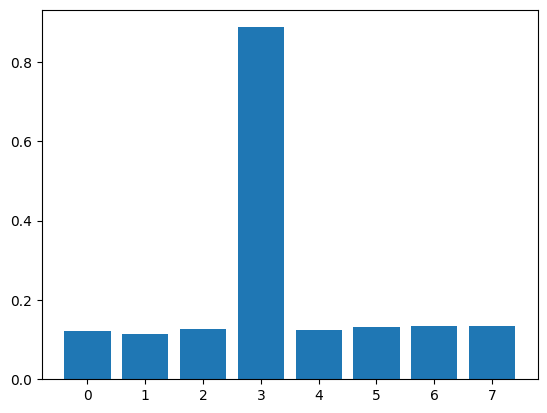

In [32]:
# collect star
total_deviation = get_total_deviation(data, 150.020)
plt.bar([i for i in range(8)], total_deviation)

<BarContainer object of 8 artists>

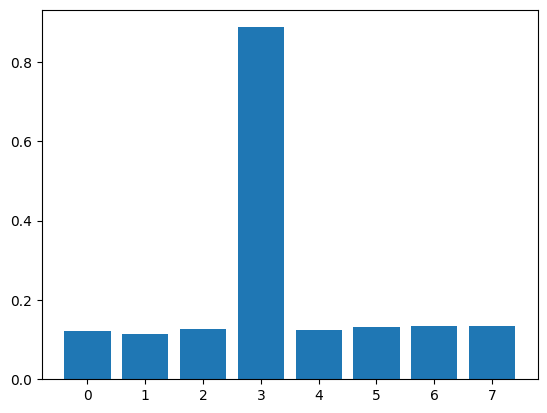

In [33]:
# collect star
total_deviation = get_total_deviation(data, 161.5900000000)
plt.bar([i for i in range(8)], total_deviation)

<BarContainer object of 8 artists>

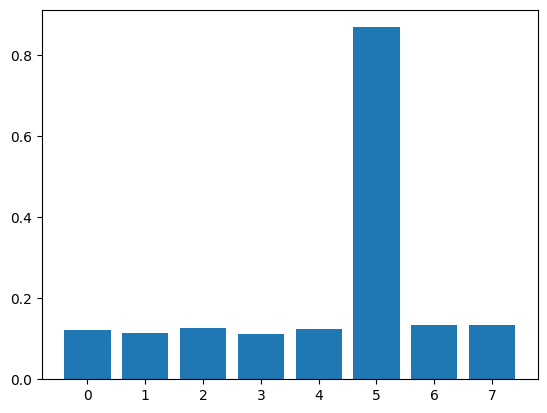

In [34]:
total_deviation = get_total_deviation(data, 176.7060000000)
plt.bar([i for i in range(8)], total_deviation)